## Recommendation system

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

### 1. Reading and Exploring the Dataset

In [2]:
MR = pd.read_csv("Data/ratings_electronics.csv",header = None)
MR.head()

,0,1,2,3
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


#### The Data Does not have column name so we will be assigning column names for easier understanding

In [3]:
MR.columns = ['userid', 'productid', 'ratings', 'timestamp']
print(MR.shape)
MR.head(10)

(7824482, 4)


,userid,productid,ratings,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200
5,A1QGNMC6O1VW39,0511189877,5.0,1397433600
6,A3J3BRHTDRFJ2G,0511189877,2.0,1397433600
7,A2TY0BTJOTENPG,0511189877,5.0,1395878400
8,A34ATBPOK6HCHY,0511189877,5.0,1395532800
9,A89DO69P0XZ27,0511189877,5.0,1395446400


#### The data has 7,824,482 records and 4 attributes. 
#### Lets Check for null values

In [4]:
MR.isnull().sum()

userid       0
productid    0
ratings      0
timestamp    0
dtype: int64

#### There are no null Values so we will proceed with droping of timestamp feature since we dont need that.

In [5]:
MR.drop('timestamp', axis = 1 , inplace = True)
MR.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824482 entries, 0 to 7824481
Data columns (total 3 columns):
userid       object
productid    object
ratings      float64
dtypes: float64(1), object(2)
memory usage: 179.1+ MB


In [6]:
MR.describe().T

,count,mean,std,min,25%,50%,75%,max
ratings,7824482.0,4.012337,1.38091,1.0,3.0,5.0,5.0,5.0


Text(0.5, 0, 'ratings')

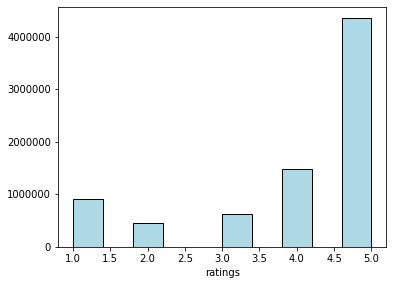

In [7]:
plt.figure(figsize= (20,15))
plt.subplot(3,3,1)
plt.hist(MR.ratings, color='lightblue', edgecolor = 'black')
plt.xlabel('ratings')

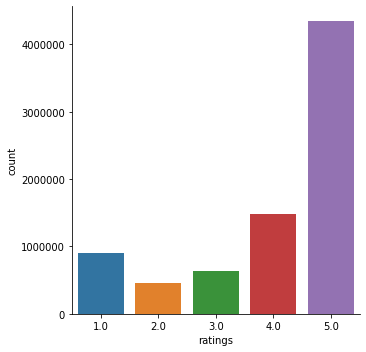

In [8]:
sns.factorplot("ratings", data=MR, kind='count')
plt.show()

In [9]:
print(MR['ratings'].value_counts(normalize = True))

5.0    0.555633
4.0    0.189889
1.0    0.115249
3.0    0.080909
2.0    0.058320
Name: ratings, dtype: float64


#### The above graph The ratings '5' has 55% of the data alligned to it with '4' following it with nearly 19 percent of the rest. It is left skewed

### 2. Creating a Subset of the Data

#### Here we will make the data less denser based on the users who have give more number of ratings than the users who has given ratings lesser number of times.

In [10]:
ratings_count = MR['userid'].value_counts()
ratings_count

A5JLAU2ARJ0BO     520
ADLVFFE4VBT8      501
A3OXHLG6DIBRW8    498
A6FIAB28IS79      431
A680RUE1FDO8B     406
                 ... 
A1CCDN2YC1CAD0      1
A3HEZIIPZA0ORS      1
A2N9ED8BLFZ9WM      1
A3C7MDMKEH8GGS      1
A3U5KBH90NLV1I      1
Name: userid, Length: 4201696, dtype: int64

#### We will first check the size of the number of records for 40 , 45 and 50 ratings count of user. if the difference is small we can take the data which has slightly higher number of entries for better tuning

In [11]:
MR1 = MR[MR['userid'].isin(ratings_count[ratings_count>=50].index.values)]
MR1.shape

(125871, 3)

In [12]:
MR2 = MR[MR['userid'].isin(ratings_count[ratings_count>=45].index.values)]
MR2.shape

(148163, 3)

In [13]:
MR3 = MR[MR['userid'].isin(ratings_count[ratings_count>=40].index.values)]
MR3.shape

(174506, 3)

#### i will consider taking MR1 which is nearly 1:6 of the original data compared to MR2 which is 1:5 of the original data MR1 is less denser than MR2 since almost 23k records gets added to the next one . and from these 2 we dont even want to consider MR3 we can outright reject it

#### Lets see the distribution of the data on MR1

In [14]:
MR1.describe(include = "all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
userid,125871,1540,A5JLAU2ARJ0BO,520,NaN,NaN,NaN,NaN,NaN,NaN,NaN
productid,125871,48190,B0088CJT4U,206,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ratings,125871,NaN,NaN,NaN,4.26134,1.06214,1,4,5,5,5


There are 1540 unique users and 48190 unique products. 

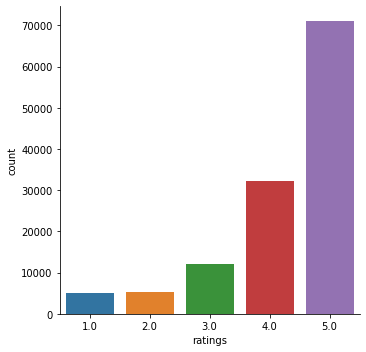

In [15]:
sns.factorplot("ratings", data=MR1, kind='count')
plt.show()

In [16]:
print(MR1['ratings'].value_counts(normalize = True))

5.0    0.564340
4.0    0.256572
3.0    0.095812
2.0    0.042639
1.0    0.040637
Name: ratings, dtype: float64


#### It is notable that the data distribution in the filtered dataset is almost similar to the original data except the difference is very little and can be ignored. 
The data distribution is comprised of 82% of ratings 4 and 5

### 3. Popularity Recommender Model

In [17]:
prod_ratings_count = MR1['productid'].value_counts()
prod_ratings_count

B0088CJT4U    206
B003ES5ZUU    184
B000N99BBC    167
B007WTAJTO    164
B00829TIEK    149
             ... 
B000062XUQ      1
B0006SE3K4      1
B004EFH6L8      1
B000HPXO2O      1
B00756KJBC      1
Name: productid, Length: 48190, dtype: int64

In [18]:
MRX = MR1[MR1['productid'].isin(prod_ratings_count[prod_ratings_count>=50].index.values)]
MRX.shape

(6234, 3)

#### For this popularity based model i have created a subest again from the subset with the products having more than 50 ratings count too.

In [19]:
MRX.head(10)

,userid,productid,ratings
72043,A2YRX8J4WM5BRX,B00004ZCJE,5.0
72059,AU627A4UGIW6V,B00004ZCJE,5.0
72077,A16RL0RMRF974O,B00004ZCJE,5.0
72121,AR8LWDT6TUKNZ,B00004ZCJE,5.0
72122,AD9ZL63H0VKCZ,B00004ZCJE,5.0
72204,A32T2H8150OJLU,B00004ZCJE,3.0
72271,AHR86ZEYETLJI,B00004ZCJE,5.0
72288,A2HMF8ZR67BNZS,B00004ZCJE,5.0
72316,A11P105WVK5240,B00004ZCJE,5.0
72326,AU2UJF4I7KAWL,B00004ZCJE,5.0


In [20]:
MRX1 = pd.DataFrame(MRX.groupby("productid").mean()['ratings'])
MRX1.rename(columns ={'ratings' : 'Average_Rating'}, inplace = True)

MRX1['num_ratings'] = pd.DataFrame(MRX.groupby(by='productid').count()["userid"])

MRX1 = MRX1.reset_index()

New Dataframe is created with 2 columns along with the product id where average rating of each product is calculated and added as a new column , and the number of ratings of each products given by all the users have been added as another column

In [21]:
MRX1.head(10)

,productid,Average_Rating,num_ratings
0,B00004ZCJE,4.250000,72
1,B00007E7JU,4.416667,60
2,B0002L5R78,4.611940,67
3,B000BQ7GW8,4.777778,54
4,B000HPV3RW,4.803922,51
5,B000JE7GPY,4.615385,52
6,B000JMJWV2,4.625000,64
7,B000LRMS66,4.450704,71
8,B000N99BBC,4.772455,167
9,B000Q8UAWY,4.389831,59


In [22]:
MRX1.describe().T

,count,mean,std,min,25%,50%,75%,max
Average_Rating,77.0,4.415513,0.347255,2.987013,4.25,4.454545,4.669492,4.871795
num_ratings,77.0,80.961039,32.843505,50.000000,58.00,71.000000,92.000000,206.000000


As desired the dataframe consists of products which has minimum of 50 ratings. 
next notable thing is the maximum number of rarings given to a single product seems to be 206 with an average number of ratings is 81(80.9)

In [23]:
MRX1.shape

(77, 3)

#### There are 77 products which has more than 50 ratings

In [24]:
MRX.shape

(6234, 3)

In [25]:
MRX1.dtypes

productid          object
Average_Rating    float64
num_ratings         int64
dtype: object

<Figure size 576x432 with 0 Axes>

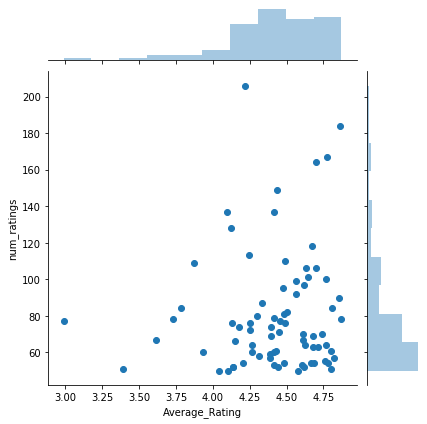

In [26]:
plt.figure(figsize=(8,6))
sns.jointplot(x='Average_Rating', y='num_ratings', data=MRX1)
plt.show()

#### Since we cannot give a very good result with just the average rating and number of ratings, i will be calculating the product of the average mean and the number of ratings given. because the higher the number of ratings gives us a bit more credible information on the product rather than less users giving higher or lower ratings on the product. 

In [27]:
MRX1['Prod_mean'] = MRX1['Average_Rating'] * MRX1['num_ratings']
MRX1

,productid,Average_Rating,num_ratings,Prod_mean
0,B00004ZCJE,4.250000,72,306.0
1,B00007E7JU,4.416667,60,265.0
2,B0002L5R78,4.611940,67,309.0
3,B000BQ7GW8,4.777778,54,258.0
4,B000HPV3RW,4.803922,51,245.0
...,...,...,...,...
72,B00BOHNYU6,4.714286,63,297.0
73,B00DR0PDNE,3.785714,84,318.0
74,B00G4UQ6U8,4.763636,55,262.0
75,B00HFRWWAM,4.500000,82,369.0


#### The popularity based recommendor system will be using the above Dataframe and suggest the user with recommendation.
#### Lets sort the Dataframe with the higher mean product as the top of the list

In [28]:
Popular_model = MRX1.sort_values(['Prod_mean'],ascending= False)
Popular_model.head(10)

,productid,Average_Rating,num_ratings,Prod_mean
28,B003ES5ZUU,4.864130,184,895.0
61,B0088CJT4U,4.218447,206,869.0
8,B000N99BBC,4.772455,167,797.0
51,B007WTAJTO,4.701220,164,771.0
56,B00829TIEK,4.436242,149,661.0
54,B00829THK0,4.416058,137,605.0
62,B008DWCRQW,4.094891,137,561.0
32,B004CLYEDC,4.669492,118,551.0
21,B002R5AM7C,4.125000,128,528.0
24,B002V88HFE,4.698113,106,498.0


#### Since popularity based recommender system is same for every user regardless of what type of user is then it can be said to be user independant. So i will be considering the choice to be given to the supplier how many popular items he want to display for the user.

In [29]:
y = input("Enter the number of recommendations that you wish to display : ")
z = int(y)

print("#====#====#====#=====#====#====#====#====#====#====#====#====#====#====#====#====#")
disp = Popular_model.head(z)
disp = disp.reset_index()
disp.drop('index', axis = 1 , inplace = True)

disp

Enter the number of recommendations that you wish to display : 18
#====#====#====#=====#====#====#====#====#====#====#====#====#====#====#====#====#


,productid,Average_Rating,num_ratings,Prod_mean
0,B003ES5ZUU,4.864130,184,895.0
1,B0088CJT4U,4.218447,206,869.0
2,B000N99BBC,4.772455,167,797.0
3,B007WTAJTO,4.701220,164,771.0
4,B00829TIEK,4.436242,149,661.0
5,B00829THK0,4.416058,137,605.0
6,B008DWCRQW,4.094891,137,561.0
7,B004CLYEDC,4.669492,118,551.0
8,B002R5AM7C,4.125000,128,528.0
9,B002V88HFE,4.698113,106,498.0


#### The above gives us the required number of reccomendation from the list as required by the user
#### In the Popularity based recommender model i have used the sort function to sort the records based on the Prod_mean column. Then used the top elements with the head function to display the required number of Recommendations for the user.

### 5. Collaborative Filtering Model

#### I will be using the data which is filtered for the uers who has given more than 50 ratings for the train test split.

### User based collaborative filtering

In [30]:
from surprise import KNNWithMeans
from collections import defaultdict
from surprise import Reader
from surprise import Dataset
from surprise import accuracy
from surprise.model_selection import train_test_split

In [31]:
reader = Reader(rating_scale=(1, 5))
col_prod = Dataset.load_from_df(MR1, reader)

In [32]:
col_prod

#### The train test split for the knn model with usage of surprise library

In [33]:
col_train , col_test = train_test_split(col_prod, test_size = .3, random_state = 8)

In [34]:
col_train

Here i have used user based model since for item based since im having memory shortage and its throwing memory error. i did not want to shorten the dataset anymore because it will give me low accuracy.

In [35]:
col_knn = KNNWithMeans(k = 7, sim_options = {'name': 'pearson_baseline', 'user_based': True})
col_knn.fit(col_train)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [36]:
col_train.n_users

1540

In [37]:
Test_predct = col_knn.test(col_test)
Test_predct

[Prediction(uid='A27Y4OEC9MD9PA', iid='B0023ZK2TY', r_ui=5.0, est=4.9411764705882355, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='A25WJCAP606YMP', iid='B0034CL2ZI', r_ui=5.0, est=4.318181818181818, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='A2JOPUWVV0XQJ3', iid='B00DIFIM36', r_ui=5.0, est=3.659090909090909, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='ADOR3TR7GDF68', iid='B00AZW2YKC', r_ui=1.0, est=4.262005016513637, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='A3BNMHRW2R35LK', iid='B004CLYEDC', r_ui=5.0, est=4.524693047065317, details={'actual_k': 7, 'was_impossible': False}),
 Prediction(uid='A2XRMQA6PJ5ZJ8', iid='B004GIKJXK', r_ui=5.0, est=4.262005016513637, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='A1T1YSCDW0PD25', iid='B007RIFKUS', r_ui=4.0, est=4.371621621621622, details={'actual_k': 0, 'was_impossible': False

In [38]:
uid = 'A2WCFDOCS73PNB'
iid = 'B005CG2AL4'

In [39]:
pred = col_knn.predict(uid, iid, verbose = True)

user: A2WCFDOCS73PNB item: B005CG2AL4 r_ui = None   est = 4.72   {'actual_k': 1, 'was_impossible': False}


From here we can see which k does the user and the corresponding product belongs. This can be used to display the top product for the user.

In [40]:
def get_top_n(Test_predct, n  = 5):
    top_n = defaultdict(list)
    
    for uid, iid, true_r, est, _ in Test_predct:
        top_n[uid].append((iid, est))
        
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key = lambda x: x[1], reverse = True)
        top_n[uid] = user_ratings[:n]
        
    return top_n

In [41]:
top_n = get_top_n(Test_predct)

The top 5 items for each user is displayed below

In [42]:
top_n

defaultdict(list,
            {'A27Y4OEC9MD9PA': [('B0023ZK2TY', 4.9411764705882355),
              ('B00009R6WU', 4.9411764705882355),
              ('B003Y30334', 4.9411764705882355),
              ('B003LR7ME6', 4.9411764705882355),
              ('B0039ORBLK', 4.9411764705882355)],
             'A25WJCAP606YMP': [('B009YT6PPC', 4.891166818928159),
              ('B00BG5M93Y', 4.843605546995378),
              ('B004IZN3WU', 4.358181818181818),
              ('B0034CL2ZI', 4.318181818181818),
              ('B0038LILTK', 4.318181818181818)],
             'A2JOPUWVV0XQJ3': [('B0052SCU8U', 4.595058056920653),
              ('B000E3B7KA', 4.262005016513637),
              ('B00356HIBU', 4.262005016513637),
              ('B0042X8W0Q', 4.262005016513637),
              ('B001F51GU2', 4.262005016513637)],
             'ADOR3TR7GDF68': [('B00005T3G0', 4.837719298245615),
              ('B004XC6GJ0', 4.568894060372246),
              ('B002HGFKR8', 4.414955070603338),
              ('B00BG

In [43]:
KNN_RMSE =  accuracy.rmse(Test_predct, verbose=True)
KNN_RMSE

RMSE: 1.0556


1.0556468885804202

In [44]:
KNN_MSE = accuracy.mse(Test_predct, verbose  = True)
KNN_MSE

MSE: 1.1144


1.114390353369522

In [45]:
KNN_MAE = accuracy.mae(Test_predct, verbose = True)
KNN_MAE

MAE:  0.7767


0.7766905682544004

#### The performance of this model is not good enough so i will try SVD model

### SVD

Creating a pivot table for the data

In [46]:
colab_data = pd.pivot_table(MR1,index='userid', columns = 'productid', values = "ratings")
colab_data.head()

productid,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
userid,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A100WO06OQR8BQ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A105S56ODHGJEK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A105TOJ6LTVMBG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A10AFVU66A79Y1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


There are lots of NaN visible on this so lets go ahead and check the saprcity of the matrix before we split it into Train and test

In [48]:
# x is the sum of all the null values present in the table
x = sum(colab_data.isnull().sum().values)
print("Total number of null values     : " + str(x))

# y is size of the matrix
y = colab_data.shape[0]*colab_data.shape[1]
print("Total size of the Matrix        : " + str(y))

# z is the half of the size of matrix
z = y/2
print("Size of the Matrix divided by 2 : " + str(z))

Total number of null values     : 74086729
Total size of the Matrix        : 74212600
Size of the Matrix divided by 2 : 37106300.0


In [49]:
print("The Matrix is sparse since half size of the matrix(" + str(z) + ") is lesser than the total number of null values(" + str(x) + ") present")

The Matrix is sparse since half size of the matrix(37106300.0) is lesser than the total number of null values(74086729) present


In [50]:
colab_data.fillna(0,inplace=True)
print(colab_data.shape)
colab_data.head()

(1540, 48190)


productid,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
userid,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105S56ODHGJEK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105TOJ6LTVMBG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10AFVU66A79Y1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [51]:
import numpy as np
from scipy.sparse.linalg import svds
from sklearn.model_selection import train_test_split

I have used the pivot table to split into test and train data because this will not have any products missing between the split.

In [52]:
train_prod, test_prod = train_test_split(colab_data, test_size = 0.30, random_state=8)

In [53]:
train_prod.shape

(1078, 48190)

In [54]:
test_prod.shape

(462, 48190)

In [55]:
U, sigma, Vt = svds(train_prod, k = 50)
sigma = np.diag(sigma)

#### using the scipy libray i have calculate the values of 'U' , 'sigma' and 'V transpose'

In [56]:
predicted_train_ratings = np.dot(np.dot(U, sigma), Vt) 

pred_train_final = pd.DataFrame(predicted_train_ratings, columns = train_prod.columns,index = train_prod.index)
pred_train_final.head()

productid,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
userid,,,,,,,,,,,,,,,,,,,,,
ARC5ASW9CUAGP,0.0,0.021804,-0.006260,0.001945,0.005873,0.006783,-0.002722,0.000434,0.014335,0.005941,...,0.001126,0.083165,0.017291,0.057234,0.032209,0.002164,0.005423,0.029616,0.0,-0.014977
A24RCBRDXRXR0Y,0.0,0.003330,0.019822,0.003433,0.015146,0.008519,0.030332,-0.000161,0.000690,0.007861,...,-0.000225,0.042892,0.001544,-0.006554,0.003860,-0.000118,0.001305,-0.014420,0.0,-0.035309
A1Z7U9K6X3FEOU,0.0,0.002387,-0.009778,-0.000169,0.002630,0.001022,-0.002088,0.000057,-0.000055,0.000635,...,-0.001133,-0.012887,-0.001593,-0.004329,-0.000179,0.003170,0.000086,-0.005808,0.0,-0.044758
A186697K4XKXQL,0.0,-0.001321,-0.012870,0.006356,-0.000931,-0.004339,0.007902,0.000658,-0.001331,-0.004187,...,-0.000564,-0.018876,-0.001427,-0.016050,-0.011047,-0.004474,0.005970,-0.037350,0.0,-0.013341
A12LH2100CKQO,0.0,0.006255,-0.002361,0.000601,0.001213,-0.000844,-0.002277,-0.000046,0.011537,-0.000196,...,-0.000454,0.013037,0.002991,0.000414,-0.001218,0.000596,0.003100,0.065175,0.0,-0.009145


#### using the derived value of 'u' , 'sigma' and 'V transpose the preridiction is calculated and recored in a new dataframe for the upcoming usage and comparison

In [57]:
actual_train_ratings_mean = train_prod.mean().head()
actual_train_ratings_mean.head()

productid
0594451647    0.000000
0594481813    0.002783
0970407998    0.003711
0972683275    0.008349
1400501466    0.018553
dtype: float64

In [58]:
predicted_train_ratings_mean = pred_train_final.mean().head()
predicted_train_ratings_mean.head()

productid
0594451647    0.000000
0594481813    0.004704
0970407998    0.006896
0972683275    0.003433
1400501466    0.007816
dtype: float64

In [59]:
U_test, sigma_test, Vt_test = svds(test_prod, k = 50)
sigma_test = np.diag(sigma_test)

In [60]:
predicted_test_ratings = np.dot(np.dot(U_test, sigma_test), Vt_test) 

pred_test_final = pd.DataFrame(predicted_test_ratings, columns = test_prod.columns,index = test_prod.index)
pred_test_final.head()

productid,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
userid,,,,,,,,,,,,,,,,,,,,,
A1V5TRJXTI6F01,0.010867,0.0,0.000772,0.068309,0.0,0.0,0.0,-0.000980,0.017057,0.0,...,0.0,0.0,0.0,-0.021274,0.0,0.0,0.0,-0.026593,-0.056676,0.0
A1FMU4CJLIDHR9,0.001497,0.0,0.000961,-0.014915,0.0,0.0,0.0,0.004675,0.001366,0.0,...,0.0,0.0,0.0,-0.013611,0.0,0.0,0.0,-0.017014,-0.014721,0.0
ANEXFROORI6F6,-0.002407,0.0,0.000445,-0.014956,0.0,0.0,0.0,-0.001858,0.004231,0.0,...,0.0,0.0,0.0,-0.007802,0.0,0.0,0.0,-0.009752,-0.006979,0.0
A1NZLRAZJGD99W,0.002000,0.0,0.000167,0.028739,0.0,0.0,0.0,-0.001465,-0.001023,0.0,...,0.0,0.0,0.0,-0.008117,0.0,0.0,0.0,-0.010146,0.005417,0.0
A145B8OHVNNFAJ,-0.004700,0.0,-0.000299,0.094982,0.0,0.0,0.0,0.002054,0.039132,0.0,...,0.0,0.0,0.0,0.067120,0.0,0.0,0.0,0.083900,0.070090,0.0


In [61]:
actual_test_ratings_mean = test_prod.mean().head()
actual_test_ratings_mean.head()

productid
0594451647    0.010823
0594481813    0.000000
0970407998    0.002165
0972683275    0.021645
1400501466    0.000000
dtype: float64

In [62]:
predicted_test_ratings_mean = pred_test_final.mean().head()
predicted_test_ratings_mean.head()

productid
0594451647    0.004347
0594481813    0.000000
0970407998    0.000863
0972683275    0.021427
1400501466    0.000000
dtype: float64

The Below model is based on the data with out the train test split lets check that once too

In [63]:
Uc, sigmac, Vtc = svds(colab_data, k = 50)
sigmac = np.diag(sigmac)

In [64]:
predicted_ratings = np.dot(np.dot(Uc, sigmac), Vtc) 

pred_finalx = pd.DataFrame(predicted_ratings, columns = colab_data.columns,index = colab_data.index)
pred_finalx.head()

productid,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
userid,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.005086,0.002178,0.003668,-0.040843,0.009640,0.006808,0.020659,0.000649,0.020331,0.005633,...,0.000238,-0.061477,0.001214,-0.123433,0.028490,0.016109,0.002855,-0.174568,0.011367,-0.012997
A100WO06OQR8BQ,0.002286,-0.010898,-0.000724,0.130259,0.007506,-0.003350,0.063711,-0.000674,0.016111,-0.002433,...,-0.000038,0.013766,0.001473,0.025588,-0.042103,0.004251,0.002177,-0.024362,-0.014765,0.038570
A105S56ODHGJEK,-0.001655,-0.002675,-0.007355,0.007264,0.005152,-0.003986,-0.003480,0.006961,-0.006606,-0.002719,...,-0.001708,-0.051040,0.000325,-0.054867,0.017870,-0.004996,-0.002426,0.083928,-0.112205,0.005964
A105TOJ6LTVMBG,0.001856,0.011019,-0.005910,-0.014134,0.000179,0.001877,-0.005391,-0.001709,0.004968,0.001402,...,0.000582,-0.009326,-0.000465,-0.048315,0.023302,0.006790,0.003380,0.005460,-0.015263,-0.025996
A10AFVU66A79Y1,0.001115,-0.002670,0.011018,0.014434,0.010319,0.006002,0.017151,0.003726,0.001404,0.005645,...,0.000207,0.023761,0.000747,-0.019347,-0.012749,0.001026,0.001364,-0.020580,0.011828,0.012770


In [65]:
actual_ratings_mean = colab_data.mean().head()
actual_ratings_mean.head()

productid
0594451647    0.003247
0594481813    0.001948
0970407998    0.003247
0972683275    0.012338
1400501466    0.012987
dtype: float64

In [66]:
predicted_ratings_mean = pred_finalx.mean().head()
predicted_ratings_mean.head()

productid
0594451647    0.001953
0594481813    0.002875
0970407998    0.003355
0972683275    0.010343
1400501466    0.004871
dtype: float64

### 6.Evaluation

#### calculating the mean ratings of each product on both the actual ratings and predicted ratings and making a new data frame from them

In [67]:
eval_df_train = pd.concat([actual_train_ratings_mean, predicted_train_ratings_mean],axis =1)
eval_df_train.head()

,0,1
productid,,
0594451647,0.000000,0.000000
0594481813,0.002783,0.004704
0970407998,0.003711,0.006896
0972683275,0.008349,0.003433
1400501466,0.018553,0.007816


In [68]:
eval_df_train.columns = ['actual_mean','predicted_mean']

In [69]:
eval_df_train.head()

,actual_mean,predicted_mean
productid,,
0594451647,0.000000,0.000000
0594481813,0.002783,0.004704
0970407998,0.003711,0.006896
0972683275,0.008349,0.003433
1400501466,0.018553,0.007816


In [70]:
RMSE_train = (((eval_df_train.actual_mean - eval_df_train.predicted_mean) ** 2).mean() ** 0.5)
RMSE_train

0.0055368885755807075

In [71]:
MAE_train = (abs(eval_df_train.actual_mean - eval_df_train.predicted_mean)).mean()
MAE_train

0.004151908215279634

In [72]:
eval_df_test = pd.concat([actual_test_ratings_mean, predicted_test_ratings_mean],axis =1)
eval_df_test.head()

,0,1
productid,,
0594451647,0.010823,0.004347
0594481813,0.000000,0.000000
0970407998,0.002165,0.000863
0972683275,0.021645,0.021427
1400501466,0.000000,0.000000


In [73]:
eval_df_test.columns = ['actual_mean','predicted_mean']
eval_df_test.head()

,actual_mean,predicted_mean
productid,,
0594451647,0.010823,0.004347
0594481813,0.000000,0.000000
0970407998,0.002165,0.000863
0972683275,0.021645,0.021427
1400501466,0.000000,0.000000


In [74]:
RMSE_test = (((eval_df_test.actual_mean - eval_df_test.predicted_mean) ** 2).mean() ** 0.5)
RMSE_test

0.0029552951725188258

In [75]:
MAE_test = (abs(eval_df_test.actual_mean - eval_df_test.predicted_mean)).mean()
MAE_test

0.001598928391591

In [76]:
eval_df = pd.concat([actual_ratings_mean, predicted_ratings_mean],axis =1)
eval_df.head()

,0,1
productid,,
0594451647,0.003247,0.001953
0594481813,0.001948,0.002875
0970407998,0.003247,0.003355
0972683275,0.012338,0.010343
1400501466,0.012987,0.004871


In [77]:
eval_df.columns = ['actual_mean','predicted_mean']
eval_df.head()

,actual_mean,predicted_mean
productid,,
0594451647,0.003247,0.001953
0594481813,0.001948,0.002875
0970407998,0.003247,0.003355
0972683275,0.012338,0.010343
1400501466,0.012987,0.004871


In [78]:
RMSE = (((eval_df.actual_mean - eval_df.predicted_mean) ** 2).mean() ** 0.5)
RMSE

0.003805315260457349

In [79]:
MAE = (abs(eval_df.actual_mean - eval_df.predicted_mean)).mean()
MAE

0.0024882511409359395

In [80]:
print("The RMSE of KNN model is       : " + str(KNN_RMSE) )
print("The RMSE of SVD Train Model is : " + str(RMSE_train))
print("The RMSE of SVD Test Model is  : " + str(RMSE_test))
print("The RMSE of the SVD model 2 is : " + str(RMSE))

print(" <===================================================>")
print("The MAE of KNN model is        : " + str(KNN_MAE))
print("The MAE of SVD Train Model is  : " + str(MAE_train))
print("The MAE of SVD Test Model is   : " + str(MAE_test))
print("The MAE of the SVD model 2 is  : " + str(MAE))

The RMSE of KNN model is       : 1.0556468885804202
The RMSE of SVD Train Model is : 0.0055368885755807075
The RMSE of SVD Test Model is  : 0.0029552951725188258
The RMSE of the SVD model 2 is : 0.003805315260457349
 <===================================================>
The MAE of KNN model is        : 0.7766905682544004
The MAE of SVD Train Model is  : 0.004151908215279634
The MAE of SVD Test Model is   : 0.001598928391591
The MAE of the SVD model 2 is  : 0.0024882511409359395


#### We can clearly see the improvement of the RMSE value for the SVD model where it uses the matrix factorization
The RMSE of SVD model is much less than the KNN model and its the same for their respective MAE.

### 7. Predicting Recommendations

Now for the next step we will be using a fucntion to predict the top 5 recommendation for the user based on the svd model with the actual and predicted ratings as our deciding factors

In [81]:
colab_data1 = pd.concat([train_prod, test_prod], axis=0)
colab_data1.head()

productid,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
userid,,,,,,,,,,,,,,,,,,,,,
ARC5ASW9CUAGP,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A24RCBRDXRXR0Y,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1Z7U9K6X3FEOU,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A186697K4XKXQL,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A12LH2100CKQO,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [82]:
pred_final = pd.concat([pred_train_final, pred_test_final], axis=0)
pred_final.head()

productid,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
userid,,,,,,,,,,,,,,,,,,,,,
ARC5ASW9CUAGP,0.0,0.021804,-0.006260,0.001945,0.005873,0.006783,-0.002722,0.000434,0.014335,0.005941,...,0.001126,0.083165,0.017291,0.057234,0.032209,0.002164,0.005423,0.029616,0.0,-0.014977
A24RCBRDXRXR0Y,0.0,0.003330,0.019822,0.003433,0.015146,0.008519,0.030332,-0.000161,0.000690,0.007861,...,-0.000225,0.042892,0.001544,-0.006554,0.003860,-0.000118,0.001305,-0.014420,0.0,-0.035309
A1Z7U9K6X3FEOU,0.0,0.002387,-0.009778,-0.000169,0.002630,0.001022,-0.002088,0.000057,-0.000055,0.000635,...,-0.001133,-0.012887,-0.001593,-0.004329,-0.000179,0.003170,0.000086,-0.005808,0.0,-0.044758
A186697K4XKXQL,0.0,-0.001321,-0.012870,0.006356,-0.000931,-0.004339,0.007902,0.000658,-0.001331,-0.004187,...,-0.000564,-0.018876,-0.001427,-0.016050,-0.011047,-0.004474,0.005970,-0.037350,0.0,-0.013341
A12LH2100CKQO,0.0,0.006255,-0.002361,0.000601,0.001213,-0.000844,-0.002277,-0.000046,0.011537,-0.000196,...,-0.000454,0.013037,0.002991,0.000414,-0.001218,0.000596,0.003100,0.065175,0.0,-0.009145


In [83]:
def recommendation(user, colab_data1, pred_final):
    
    # we will create a list for the users seperately here so that we can get the items which are very specific for the users
    # The below code sorts out the recommendation dataframe based on the user
    
    ur = colab_data1.loc[user].sort_values(ascending=False)
    pr = pred_final.loc[user].sort_values(ascending=False)
    recommend = pd.concat([ur, pr], axis=1)
    recommend.index.name = 'Recommended Items'
    recommend.columns = ['actual_ratings', 'predicted_ratings']
    
    #recommend.head()    
    
    # i will be displaying the items which has high predicted ratings as well as those which are unrated by the user
    recommend = recommend.loc[recommend.actual_ratings == 0]   
    recommend = recommend.sort_values('predicted_ratings', ascending=False)
    
    n = int(input("Enter the number of recommendations to be displayed : "))
    print('The Prducts Recommended for the User {} :'.format(user))
    print(recommend.head(n))

In [84]:
colab_data1.head()

productid,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
userid,,,,,,,,,,,,,,,,,,,,,
ARC5ASW9CUAGP,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A24RCBRDXRXR0Y,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1Z7U9K6X3FEOU,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A186697K4XKXQL,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A12LH2100CKQO,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [85]:
u = input("Enter the user id: ")
recommendation(u,colab_data1,pred_final)

Enter the user id: ARC5ASW9CUAGP
Enter the number of recommendations to be displayed : 5
The Prducts Recommended for the User ARC5ASW9CUAGP :
                   actual_ratings  predicted_ratings
Recommended Items                                   
B000QUUFRW                    0.0           0.894458
B001TH7GUU                    0.0           0.680211
B004G6002M                    0.0           0.607201
B002V88HFE                    0.0           0.569730
B0041Q38NU                    0.0           0.545773


In [86]:
colab_data1.tail(10)

productid,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
userid,,,,,,,,,,,,,,,,,,,,,
A1MRRMHGV3PN5W,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A3NGOG8Z78AZSD,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1QJ10LEINDRWW,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A361M14PU2GUEG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A3S5WYWYKSAI9C,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A3J2YU2D9BH2J7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A3SL0HA6422W4M,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A3V2EZ6MA32FF6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1R6RKKE44AYA8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [87]:
u = input("Enter the user id: ")
recommendation(u,colab_data1,pred_final)

Enter the user id: A1MRRMHGV3PN5W
Enter the number of recommendations to be displayed : 8
The Prducts Recommended for the User A1MRRMHGV3PN5W :
                   actual_ratings  predicted_ratings
Recommended Items                                   
B00829TIEK                    0.0           1.369168
B00829TIA4                    0.0           1.001954
B00ARB5FLQ                    0.0           0.851986
B002R5AM7C                    0.0           0.747741
B0088PPFP4                    0.0           0.691499
B004CLYEFK                    0.0           0.630472
B00834SJNA                    0.0           0.606779
B008I21EA2                    0.0           0.606710


Below i will be using the table which i did not split into train and test set and use those predictions to recommend the products for the user since the RMSE and MAE is better for this

In [88]:
def recommendation1(user, colab_data, pred_finalx):
        
    ur = colab_data.loc[user].sort_values(ascending=False)
    pr = pred_finalx.loc[user].sort_values(ascending=False)
    recommend = pd.concat([ur, pr], axis=1)
    recommend.index.name = 'Recommended Items'
    recommend.columns = ['actual_ratings', 'predicted_ratings']

    recommend = recommend.loc[recommend.actual_ratings == 0]   
    recommend = recommend.sort_values('predicted_ratings', ascending=False)
    
    n = int(input("Enter the number of recommendations to be displayed : "))
    print('The Prducts Recommended for the User {} :'.format(user))
    print(recommend.head(n))

In [89]:
u = input("Enter the user id: ")
recommendation1(u,colab_data,pred_finalx)

Enter the user id: A12LH2100CKQO
Enter the number of recommendations to be displayed : 5
The Prducts Recommended for the User A12LH2100CKQO :
                   actual_ratings  predicted_ratings
Recommended Items                                   
B0041Q38NU                    0.0           0.388290
B000LRMS66                    0.0           0.381645
B00DVFLJDS                    0.0           0.375487
B000JE7GPY                    0.0           0.360242
B000JMJWV2                    0.0           0.319584


In [90]:
u = input("Enter the user id: ")
recommendation1(u,colab_data,pred_finalx)

Enter the user id: A1R6RKKE44AYA8
Enter the number of recommendations to be displayed : 9
The Prducts Recommended for the User A1R6RKKE44AYA8 :
                   actual_ratings  predicted_ratings
Recommended Items                                   
B007WTAJTO                    0.0           0.630178
B002V88HFE                    0.0           0.423358
B00BOHNYTW                    0.0           0.385471
B00829THK0                    0.0           0.385076
B002WE4HE2                    0.0           0.384545
B001XURP7W                    0.0           0.341302
B005FYNSPK                    0.0           0.340298
B00834SJNA                    0.0           0.299394
B000JMJWV2                    0.0           0.285874


### Summary

1. The data set has 4 columns "userid, productid, ratings, timestamp" with the size of 7824482 records. Since we wont be needing the time stamp we will be dropping the column. Next step is to check the presence of missing values. There were none found in this data set.

2. since the data set was huge i have tried to create a 3 types of subsets with the number of ratings user has given as the filter criteria and one with 50, 45 and 40 number of ratings respectively. After a thorough consideration i prefered the one with 50 rating count or more because the data set tends to grow a lot for the next 2 and there might come a memory issues. The data is leening towards 5 because around 56 % of the data has the ratings 5 followed by 4 and almost equally distributed for the rest.

3. I built a popularity based recommendation model as a first model.This model does not need to know about the characteristics of the user so, i have calculated the top most rated products and displayed the results. I have further cleaned the data for the products which have more than 50 ratings. The selction if just done with avearage ratings wone give us much accuracy since if a single user rated 5 it will obviously give us a 5 and will come out on top of the list. To avoid this scenario i have multiplied the "average of the user rating" and "number of user ratings" and made a new column product of the ratings and sorted it out with highest on top. In this model i have given the choice to the user how many popular recommendations he would like to display.

4. Train test split is done for model in the colaborative filtering for the "surprise KNN model" with 70:30 ratio and a random state of 8.

5. The KNN model is built based on the the surprise library and it is based on the user based collaborative filtering. i have tried the item based too but it is giving me memory error. i did not want to reduce the size of the data anymore so i did not proceed with the model since i need to reduce the size in a very considerable way. after the training of the model the test RMSE is "1.0556"

6. Next we go for the SVD model. The matrix was a sprse matrix so i filled it with 0 for the empty slot. I have used two ways for this model. In the first method i have used the train test split and ran the train and test data to make the ratings prediction. The the predicted table is created for both train and test set. In the second model i have created a prediction table for the whole of the data. The vaues " U, sigma and V transpose " are calculated using these parameters the new data frame with the predicted values are calculated for both the models. Then the data are combined with the mean of the predicted and actual ratings for every product.

7. Now when we evaluate the models the popularity model is unaffected since it recommends the rop rated ones. and when we compare the user based model and SVD. SVD has the better rmse when compared to the user based colaborative model(KNN model). so i used svd to predict the k number of recommendations. The recommendations are given in a form where the user can enter how many recommendations he needs. In the first SVD model where the train and test split is done and prediction is made is having a RMSE and MAE much higher when we compare it with the second model where the prediction is done with the whole of the data. so i personally prefer splitin the data for this model is not much good and more the data will give us less errors and much good evaluation.

8. if we notice the popularity based model, it recommends the same products regardless of the users, but if we notice the SVD model it gives different otucome for the different users. Showing out this as an example i have displayed the recommendations of 4 different tyes of users as u can notice. In the colaborative filtering it is because the RMSE and MAE of the svd is much better than the user based i choose to use the SVD as the final model. I have used both the SVD model for the display of the recommendations where the model with the train test split is used for the first 2 display and the second model where the whole data is used is displaying the last 2 recommendations